# Amazon Augmented AI (Amazon A2I) integration with Amazon Fraud Detector

# Visit https://github.com/aws-samples/amazon-a2i-sample-jupyter-notebooks for all A2I Sample Notebooks


1. [Introduction](#Introduction)
2. [Prerequisites](#Setup)
    1. [Workteam](#Workteam)
    2. [Notebook Permission](#Notebook-Permission)
3. [Client Setup](#Client-Setup)
4. [Create Control Plane Resources](#Create-Control-Plane-Resources)
    1. [Create Human Task UI](#Create-Human-Task-UI)
    2. [Create Flow Definition](#Create-Flow-Definition)
5. Scenario: When Activation Conditions are met, and a Human Loop is created
    1. [Check Status of Human Loop](#Check-Status-of-Human-Loop)
    2. [Wait For Workers to Complete Task](#Wait-For-Workers-to-Complete-Task)
    3. [Check Status of Human Loop](#Check-Status-of-Human-Loop)
    4. [View Task Results](#View-Task-Results)

# Introduction

Amazon Augmented AI (Amazon A2I) makes it easy to build the workflows required for human review of ML predictions. Amazon A2I brings human review to all developers, removing the undifferentiated heavy lifting associated with building human review systems or managing large numbers of human reviewers. 

Amazon A2I provides built-in human review workflows for common machine learning use cases, such as content moderation and text extraction from documents, which allows predictions from Amazon Rekognition and Amazon Textract to be reviewed easily. You can also create your own workflows for ML models built on Amazon SageMaker or any other tools. Using Amazon A2I, you can allow human reviewers to step in when a model is unable to make a high confidence prediction or to audit its predictions on an on-going basis. Learn more here: https://aws.amazon.com/augmented-ai/

In this tutorial, we will show how you can use Amazon A2I directly with Amazon Fraud Detector to check for high confidence fraud predictions

For more in depth instructions, visit https://docs.aws.amazon.com/sagemaker/latest/dg/a2i-getting-started.html

To incorporate Amazon A2I into your human review workflows, you need three resources:

* A **worker task template** to create a worker UI. The worker UI displays your input data, such as documents or images, and instructions to workers. It also provides interactive tools that the worker uses to complete your tasks. For more information, see https://docs.aws.amazon.com/sagemaker/latest/dg/a2i-instructions-overview.html

* A **human review workflow**, also referred to as a flow definition. You use the flow definition to configure your human workforce and provide information about how to accomplish the human review task. For built-in task types, you also use the flow definition to identify the conditions under which a review human loop is triggered.  You can use the flow definition to specify that a model prediction will be sent to a human for review based on the threshold defined by you for Fraud detection. You can create a flow definition in the Amazon Augmented AI console or with the Amazon A2I APIs. To learn more about both of these options, see https://docs.aws.amazon.com/sagemaker/latest/dg/a2i-create-flow-definition.html

* A **human loop** to start your human review workflow. When you use one of the built-in task types, the corresponding AWS service creates and starts a human loop on your behalf when the conditions specified in your flow definition are met or for each object if no conditions were specified. When a human loop is triggered, human review tasks are sent to the workers as specified in the flow definition.

When using a custom task type, you start a human loop using the Amazon Augmented AI Runtime API. When you call StartHumanLoop in your custom application, a task is sent to human reviewers.

### Install Latest SDK

In [16]:
# First, let's get the latest installations of our dependencies
!pip install --upgrade pip
!pip install botocore --upgrade
!pip install boto3 --upgrade
!pip install -U botocore

## Setup
We need to set up the following data:
* `region` - Region to call A2I
* `bucket` - A S3 bucket accessible by the given role
    * Used to store the sample images & output results
    * Must be within the same region A2I is called from
* `role` - The IAM role used as part of StartHumanLoop. By default, this notebook will use the execution role
* `workteam` - Group of people to send the work to

In [48]:
import boto3
import botocore

REGION = boto3.session.Session().region_name

#### Create and Setup S3 Bucket and Paths
Create your own S3 bucket and replace the following with that bucket name 

In [49]:
# Replace the following with your bucket name
BUCKET = 'your amazon s3 bucket name'

Your bucket, `BUCKET` must be located in the same AWS Region that you are using to run this notebook. This cell checks if they are located in the same Region. 

In [50]:
# Amazon S3 (S3) client
s3 = boto3.client('s3', REGION)
bucket_region = s3.head_bucket(Bucket=BUCKET)['ResponseMetadata']['HTTPHeaders']['x-amz-bucket-region']
assert bucket_region == REGION, "Your S3 bucket {} and this notebook need to be in the same region.".format(BUCKET)

### Notebook Permission

The AWS IAM Role used to execute the notebook needs to have the following permissions:

* FraudDetectorFullAccess
* SagemakerFullAccess
* AmazonSageMakerMechanicalTurkAccess (if using MechanicalTurk as your Workforce)
* S3 Read and Write Access to the bucket you specified in `BUCKET`. 


In [51]:
from sagemaker import get_execution_role

# Setting Role to the default SageMaker Execution Role
ROLE = get_execution_role()
display(ROLE)

'arn:aws:iam::534095625703:role/AWSDeepLensSageMakerRole'

Visit: https://docs.aws.amazon.com/sagemaker/latest/dg/a2i-permissions-security.html to add the necessary permissions to your role

### Workteam or Workforce

A workforce is the group of workers that you have selected to label your dataset. You can choose either the Amazon Mechanical Turk workforce, a vendor-managed workforce, or you can create your own private workforce for human reviews. Whichever workforce type you choose, Amazon Augmented AI takes care of sending tasks to workers. 

When you use a private workforce, you also create work teams, a group of workers from your workforce that are assigned to Amazon Augmented AI human review tasks. You can have multiple work teams and can assign one or more work teams to each job.

# To create your Workteam, visit the instructions here: https://docs.aws.amazon.com/sagemaker/latest/dg/sms-workforce-management.html

NOTE: After you have created your workteam, replace WORKTEAM_ARN below with your own Workteam ARN


In [52]:
WORKTEAM_ARN = "your workteam arn"


## Client Setup

Here we are going to setup the clients. 

In [53]:
from IPython.core.display import display, HTML
from IPython.display import clear_output
display(HTML("<style>.container { width:90% }</style>"))
# ------------------------------------------------------------------

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

import os
import sys
import time
import json
import uuid 
from datetime import datetime
import io

# -- Client setup -- 
import boto3
import sagemaker

# -- sklearn --
from sklearn.metrics import roc_curve, roc_auc_score, auc, roc_auc_score
%matplotlib inline

In [54]:
import pprint

# Pretty print setup
pp = pprint.PrettyPrinter(indent=2)

# Function to pretty-print AWS SDK responses
def print_response(response):
    if 'ResponseMetadata' in response:
        del response['ResponseMetadata']
    pp.pprint(response)

In [55]:
# Amazon SageMaker client
sagemaker = boto3.client('sagemaker', REGION)


# Amazon Augmented AI (A2I) Runtime client
a2i_runtime_client = boto3.client('sagemaker-a2i-runtime', REGION)


# -- initialize the Amazon Fraud Detector client 
client = boto3.client('frauddetector')

# Amazon Fraud Detector Set up

To generate fraud predictions, Amazon Fraud Detector uses machine learning models that are trained
with your historical fraud data. Each model is trained using a model type, which is a specialized recipe to
build a fraud detection model for a specific fraud use case. Deployed models are imported to detectors,
where you can configure decision logic (for example, rules) to interpret the model’s score and assign
outcomes such as pass or send transaction to a human investigator for review.

You can use the AWS Console to create and manage models and detector versions. Alternatively, you can
use the AWS Command Line Interface (AWS CLI) or one of the Amazon Fraud Detector SDKs.
Amazon Fraud Detector components include events, entities, labels, models, rules, variables, outcomes,
and detectors. Using these components, you can build an evaluation that contains your fraud detection
logic.
 

### To Create a fraud detector model using the console, please refer to the link below
 https://docs.aws.amazon.com/frauddetector/latest/ug/frauddetector.pdf
 
 ### To Create a fraud detector model using an SDK / Python notebook, please refer to the link below
https://github.com/aws-samples/aws-fraud-detector-samples
#### NOTE:
The following model is create using the default data set provided by Amazon Fraud Detector (at https://docs.aws.amazon.com/frauddetector/latest/ug/samples/training_data.zip)

After you create your own Fraud Detector Model, replace the MODEL_NAME, DETECTOR_NAME, EVENT_TYPE and ENTITY_TYPE with your  fraud detector model values
 

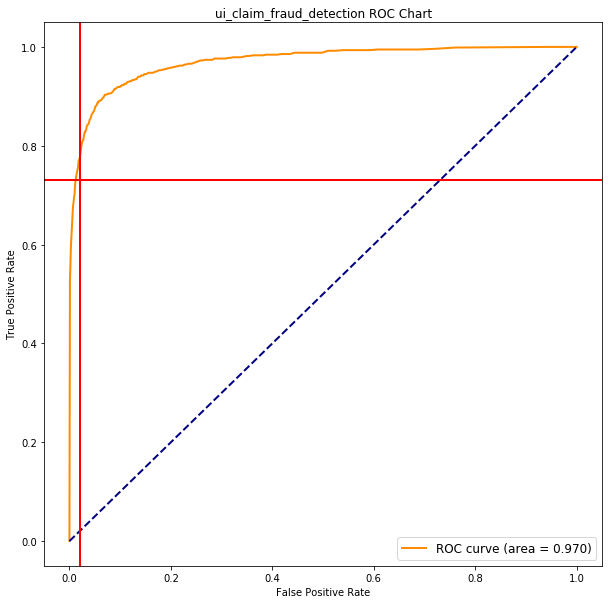

In [56]:
MODEL_NAME = 'ui_claim_fraud_detection'
DETECTOR_NAME = 'ui_claim_fraud'
EVENT_TYPE = 'ui_registration'
ENTITY_TYPE = 'ui_applicant'


# -- model performance summary -- 
auc = client.describe_model_versions(
    modelId= MODEL_NAME,
    modelVersionNumber='1.0',
    modelType='ONLINE_FRAUD_INSIGHTS',
    maxResults=10
)['modelVersionDetails'][0]['trainingResult']['trainingMetrics']['auc']


df_model = pd.DataFrame(client.describe_model_versions(
    modelId= MODEL_NAME,
    modelVersionNumber='1.0',
    modelType='ONLINE_FRAUD_INSIGHTS',
    maxResults=10
)['modelVersionDetails'][0]['trainingResult']['trainingMetrics']['metricDataPoints'])


plt.figure(figsize=(10,10))
plt.plot(df_model["fpr"], df_model["tpr"], color='darkorange',
         lw=2, label='ROC curve (area = %0.3f)' % auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title( MODEL_NAME + ' ROC Chart')
plt.legend(loc="lower right",fontsize=12)
plt.axvline(x = 0.02 ,linewidth=2, color='r')
plt.axhline(y = 0.73 ,linewidth=2, color='r')
plt.show()

### Test the fraud detector with a sample data record
Using the fraud detector client, invoke the model endpoint with a sample record and examine the results including fraud detection score

In [57]:

eventId = uuid.uuid1()
timestampStr = '2013-07-16T19:00:00Z'

# Construct a sample data record
rec = {
   'applicant_age': '45',
   'applicant_name': 'Robert Moreno',
   'closest_emp_office' : 'Apex',
   'contact_method' : 'email',
   'date_of_birth' : '1/4/92 8:49',
   'disabilty_status' :'partial',
   'document_type' : 'license',
   'email_address' :'fake_gina13@gmail.com',
   'est_monthly_inc' : '13375',
   'goverment_id' : '342-92-8104',
   'ip_address': '68.183.228.102',
   'mailing_address' : '399 Brittany Ridges Fake St',
   'phone_number': '(555)682 – 9076',
   'us_citizen' : 'resident',
   'veteran_status' : 'veteran'
}


pred = client.get_event_prediction(detectorId=DETECTOR_NAME, 
                                       detectorVersionId='1',
                                       eventId = str(eventId),
                                       eventTypeName = EVENT_TYPE,
                                       eventTimestamp = timestampStr, 
                                       entities = [{'entityType': ENTITY_TYPE, 'entityId':str(eventId.int)}],
                                       eventVariables=rec) 

In [58]:
pred

{'modelScores': [{'modelVersion': {'modelId': 'ui_claim_fraud_detection',
    'modelType': 'ONLINE_FRAUD_INSIGHTS',
    'modelVersionNumber': '1.0'},
   'scores': {'ui_claim_fraud_detection_insightscore': 998.0}}],
 'ruleResults': [{'ruleId': 'high_fraud_risk',
   'outcomes': ['verify_customer']}],
 'ResponseMetadata': {'RequestId': '9b15d84d-a228-4769-b229-db600c5325c3',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'date': 'Mon, 04 Jan 2021 13:56:27 GMT',
   'content-type': 'application/x-amz-json-1.1',
   'content-length': '269',
   'connection': 'keep-alive',
   'x-amzn-requestid': '9b15d84d-a228-4769-b229-db600c5325c3'},
  'RetryAttempts': 0}}

In [28]:
# Extract/print the model score
pred['modelScores'][0]['scores']['ui_claim_fraud_detection_insightscore']

998.0

# Create Control Plane Resources

Create Control Plane Resources
Create Human Task UI

Create a human task UI resource, giving a UI template in liquid html. This template will be rendered to the human workers whenever human loop is required.

For over 70 pre built UIs, check: https://github.com/aws-samples/amazon-a2i-sample-task-uis.

Here we'll be constructing the following control plane resources: Human Task UI and Flow Definition, using the SageMaker CreateTaskUI and CreateFlowDefinition APIs, respectively.

These resources can be created once and used to drive any subsequent A2I human loops.

NOTE: The following template models a "Claim" - i.e. mark if a given claim is fraudulent, valid claim or needs further investigation

In [59]:
template="""<script src="https://assets.crowd.aws/crowd-html-elements.js"></script>

<crowd-form>
      <crowd-classifier
          name="category"
          categories="['Fradulent Claim', 'Valid Claim', 'Needs furthur Investigation']"
          header="Select the most relevant category"
      >
      <classification-target>
        <h3><strong>Risk Score (out of 1000): </strong><span style="color: #ff9900;">{{ task.input.score.ui_claim_fraud_detection_insightscore}}</span></h3>
        <hr>
	<h3> Claim Details </h3>
        <p style="padding-left: 50px;"><strong>Applicant age   :  </strong>{{ task.input.taskObject.applicant_age }}</p>
        <p style="padding-left: 50px;"><strong>Applicant name  :  </strong>{{ task.input.taskObject.applicant_name }}</p>
        <p style="padding-left: 50px;"><strong>Closest Employee Office  :  </strong>{{ task.input.taskObject.closest_emp_office }}</p>
        <p style="padding-left: 50px;"><strong>Contact method    :  </strong>{{ task.input.taskObject.contact_method }}</p>
        <p style="padding-left: 50px;"><strong>Date of birth  :  </strong>{{ task.input.taskObject.date_of_birth }}</p>
        <p style="padding-left: 50px;"><strong>Disabilty status   :  </strong>{{ task.input.taskObject.disabilty_status }}</p>
        <p style="padding-left: 50px;"><strong>Document type     :  </strong>{{ task.input.taskObject.document_type }}</p>
        <p style="padding-left: 50px;"><strong>Email address  :  </strong>{{ task.input.taskObject.email_address }}</p>
        <p style="padding-left: 50px;"><strong>Originating IP  :  </strong>{{ task.input.taskObject.ip_address }}</p>
        <p style="padding-left: 50px;"><strong>Phone Number    :  </strong>{{ task.input.taskObject.phone_number }}</p>
        <p style="padding-left: 50px;"><strong>mailing_address      :  </strong>{{ task.input.taskObject.mailing_address }}</p>
      <p style="padding-left: 50px;"><strong> US Citizen :  </strong>{{ task.input.taskObject.us_citizen }}</p>
        <p style="padding-left: 50px;"><strong>Veteran status   :  </strong>{{ task.input.taskObject.veteran_status }}</p>
     </classification-target>
      
      <full-instructions header="Claim Verification instructions">
         <ol>
        <li><strong>Review</strong> the claim application and documents carefully.</li>
        <li>Mark the claim as valid or fraudulent</li>
      </ol>
      </full-instructions>

      <short-instructions>
       Choose the most relevant category that is expressed by the text. 
      </short-instructions>
    </crowd-classifier>

</crowd-form>
"""

In [60]:
def create_task_ui(task_ui_name, template):
    '''
    Creates a Human Task UI resource.

    Returns:
    struct: HumanTaskUiArn
    '''
    response = sagemaker.create_human_task_ui(
        HumanTaskUiName=task_ui_name,
        UiTemplate={'Content': template})
    return response

### Create an Augmented AI task UI

In [61]:
# Task UI name - this value is unique per account and region. You can also provide your own value here.
taskUIName = 'fraud'+ str(uuid.uuid1())

# Create task UI
humanTaskUiResponse = create_task_ui(taskUIName, template)
humanTaskUiArn = humanTaskUiResponse['HumanTaskUiArn']
print(humanTaskUiArn)

arn:aws:sagemaker:us-east-1:534095625703:human-task-ui/fraud1d45e6f8-4e96-11eb-87a7-0e1997694b91


# Create the Flow Definition¶

In this section, we're going to create a flow definition definition. Flow Definitions allow us to specify:

    The workforce that your tasks will be sent to.
    The instructions that your workforce will receive. This is called a worker task template.
    The configuration of your worker tasks, including the number of workers that receive a task and time limits to complete tasks.
    Where your output data will be stored.

This demo is going to use the API, but you can optionally create this workflow definition in the console as well.

For more details and instructions, see: https://docs.aws.amazon.com/sagemaker/latest/dg/a2i-create-flow-definition.html.


In [62]:
OUTPUT_PATH = f's3://{BUCKET}/a2i-results'

def create_flow_definition(flow_definition_name):
    '''
    Creates a Flow Definition resource

    Returns:
    struct: FlowDefinitionArn
    '''
    response = sagemaker.create_flow_definition(
            FlowDefinitionName= flow_definition_name,
            RoleArn= ROLE,
            HumanLoopConfig= {
                "WorkteamArn": WORKTEAM_ARN,
                "HumanTaskUiArn": humanTaskUiArn,
                "TaskCount": 1,
                "TaskDescription": "Please review the claim data and flag for potential fraud",
                "TaskTitle": "Review and Approve / Reject claim."
            },
            OutputConfig={
                "S3OutputPath" : OUTPUT_PATH
            }
        )
    
    return response['FlowDefinitionArn']

In [63]:
# Flow definition name - this value is unique per account and region. You can also provide your own value here.
#uniqueId = str(uuid.uuid4())
uniqueId = str(int(round(time.time() * 1000)))
flowDefinitionName = f'fraud-detector-a2i-{uniqueId}'
#flowDefinitionName = 'fraud-detector-a2i' 

flowDefinitionArn = create_flow_definition(flowDefinitionName)
print(flowDefinitionArn)

arn:aws:sagemaker:us-east-1:534095625703:flow-definition/fraud-detector-a2i-1609769227617


# Starting Human Loops

Now that we have setup our Flow Definition, we are ready to call our Amazon Fraud detector and start our human loops. 
In this tutorial, we are interested in starting a HumanLoop only if the prediction probability score returned by our model for objects detected is more than risk threshold 900.

 we will kick off a HumanLoop to engage our workforce for a human review.
# Start human loop if the model risk score exceeds a certain treshold

In [64]:

OUTPUT_PATH = f's3://{BUCKET}/a2i-results'

FraudScore= pred['modelScores'][0]['scores']['ui_claim_fraud_detection_insightscore']
print(FraudScore)

## SET YOUR OWN THRESHOLD HERE
SCORE_THRESHOLD  = 900

if FraudScore > SCORE_THRESHOLD  :
    # Create the human loop input JSON object
    humanLoopInput = {
        'score' : pred['modelScores'][0]['scores'],
        'taskObject': rec
    }

    print(json.dumps(humanLoopInput))




998.0
{"score": {"ui_claim_fraud_detection_insightscore": 998.0}, "taskObject": {"applicant_age": "45", "applicant_name": "Robert Moreno", "closest_emp_office": "Apex", "contact_method": "email", "date_of_birth": "1/4/92 8:49", "disabilty_status": "partial", "document_type": "license", "email_address": "fake_gina13@gmail.com", "est_monthly_inc": "13375", "goverment_id": "342-92-8104", "ip_address": "68.183.228.102", "mailing_address": "399 Brittany Ridges Fake St", "phone_number": "(555)682 \u2013 9076", "us_citizen": "resident", "veteran_status": "veteran"}}


# Start human loop

In [65]:
humanLoopName = 'Fraud-detector-' + str(int(round(time.time() * 1000)))
print('Starting human loop - ' + humanLoopName)

response = a2i_runtime_client.start_human_loop(
                            HumanLoopName=humanLoopName,
                            FlowDefinitionArn= flowDefinitionArn,
                            HumanLoopInput={
                                'InputContent': json.dumps(humanLoopInput)
                                }
                            )

Starting human loop - Fraud-detector-1609769259714


### Check Status of Human Loop

In [66]:
all_human_loops_in_workflow = a2i_runtime_client.list_human_loops(FlowDefinitionArn=flowDefinitionArn)['HumanLoopSummaries']

for human_loop in all_human_loops_in_workflow:
    print(f'\nHuman Loop Name: {human_loop["HumanLoopName"]}')
    print(f'Human Loop Status: {human_loop["HumanLoopStatus"]} \n')
    print('\n')



Human Loop Name: Fraud-detector-1609769259714
Human Loop Status: InProgress 





# Wait For Workers to Complete Task

Since we are using private workteam, we should go to the labling UI to perform the inspection ourselves.


In [67]:
workteamName = WORKTEAM_ARN[WORKTEAM_ARN.rfind('/') + 1:]
print("Navigate to the private worker portal and do the tasks. Make sure you've invited yourself to your workteam!")
print('https://' + sagemaker.describe_workteam(WorkteamName=workteamName)['Workteam']['SubDomain'])

Navigate to the private worker portal and do the tasks. Make sure you've invited yourself to your workteam!
https://nd0s993s52.labeling.us-east-1.sagemaker.aws


### Check Status of Human Loop

In [68]:
all_human_loops_in_workflow = a2i_runtime_client.list_human_loops(FlowDefinitionArn=flowDefinitionArn)['HumanLoopSummaries']

completed_loops = []
for human_loop in all_human_loops_in_workflow:
    print(f'\nHuman Loop Name: {human_loop["HumanLoopName"]}')
    print(f'Human Loop Status: {human_loop["HumanLoopStatus"]} \n')
    print('\n')
    if human_loop['HumanLoopStatus'] == 'Completed':
        completed_loops.append(human_loop['HumanLoopName'])



Human Loop Name: Fraud-detector-1609769259714
Human Loop Status: Completed 





In [69]:
print(completed_loops)

['Fraud-detector-1609769259714']


### View Task Results  

Once work is completed, Amazon A2I stores results in your S3 bucket and sends a Cloudwatch event. Your results should be available in the S3 OUTPUT_PATH when all work is completed.

In [70]:
import re
import pprint
pp = pprint.PrettyPrinter(indent=2)

def retrieve_a2i_results_from_output_s3_uri(bucket, a2i_s3_output_uri):
    '''
    Gets the json file published by A2I and returns a deserialized object
    '''
    splitted_string = re.split('s3://' +  bucket + '/', a2i_s3_output_uri)
    output_bucket_key = splitted_string[1]

    response = s3.get_object(Bucket=bucket, Key=output_bucket_key)
    content = response["Body"].read()
    return json.loads(content)
    

for human_loop_name in completed_loops:

    describe_human_loop_response = a2i_runtime_client.describe_human_loop(
        HumanLoopName=human_loop_name
    )
    
    print(f'\nHuman Loop Name: {describe_human_loop_response["HumanLoopName"]}')
    print(f'Human Loop Status: {describe_human_loop_response["HumanLoopStatus"]}')
    print(f'Human Loop Output Location: : {describe_human_loop_response["HumanLoopOutput"]["OutputS3Uri"]} \n')
    
    # Uncomment below line to print out a2i human answers
    pp.pprint(retrieve_a2i_results_from_output_s3_uri(BUCKET, describe_human_loop_response['HumanLoopOutput']['OutputS3Uri']))



Human Loop Name: Fraud-detector-1609769259714
Human Loop Status: Completed
Human Loop Output Location: : s3://fraud-detector-a2i/a2i-results/fraud-detector-a2i-1609769227617/2021/01/04/14/07/39/Fraud-detector-1609769259714/output.json 

{ 'flowDefinitionArn': 'arn:aws:sagemaker:us-east-1:534095625703:flow-definition/fraud-detector-a2i-1609769227617',
  'humanAnswers': [ { 'acceptanceTime': '2021-01-04T14:08:09.311Z',
                      'answerContent': { 'category': { 'label': 'Needs furthur '
                                                                'Investigation'}},
                      'submissionTime': '2021-01-04T14:16:09.886Z',
                      'timeSpentInSeconds': 480.575,
                      'workerId': '7fe4cd6b55282093',
                      'workerMetadata': { 'identityData': { 'identityProviderType': 'Cognito',
                                                            'issuer': 'https://cognito-idp.us-east-1.amazonaws.com/us-east-1_1DCLqiVmd',
       

# Cleanup
To avoid incurring unnecessary charges, delete the resources used in this
walkthrough when not in use. For instructions, see the following:

How do I delete an S3 Bucket? https://docs.aws.amazon.com/AmazonS3/latest/user-guide/delete-bucket.html

Delete a Flow Definition https://docs.aws.amazon.com/sagemaker/latest/dg/a2i-delete-flow-definition.html

Cleanup: SageMaker Resources https://sagemaker-workshop.com/cleanup/sagemaker.html
Delete Amazon Fraud detector resources https://docs.aws.amazon.com/frauddetector/latest/ug/delete-detector.html